In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

large = 40; med = 20; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
#plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [11]:
# Optical Bloch equations
def optical_bloch(x, y, z, gamma_d, gamma_r, J, L, Delta):
    eq1 = gamma_r * x - (4 * Delta + gamma_d) * y
    eq2 = -4 * J * L * z * x - 4 * Delta * x - (gamma_d + gamma_r) * y
    eq3 = 2 * J * L * x * y - gamma_r * (1 + z)
    return eq1, eq2, eq3

# Solution for steady-state variables x, y, z
def solution_set(Delta, J, L, gamma_d, gamma_r):
    # Common denominator calculation
    denominator = 2 * J * L * (4 * Delta + gamma_d)
    
    # Complex term inside the square root
    complex_term = 1 + (- 4 * Delta * (4 * Delta + gamma_d) - gamma_r**2 - gamma_r * gamma_d) / (4 * J * L * (4 * Delta + gamma_d))
    
    # x coordinate calculation (positive and negative solutions)
    x_pos = ( (4 * Delta + gamma_d) / np.sqrt(denominator) ) * np.sqrt(complex_term)
    x_neg = -x_pos
    
    # y coordinate calculation (positive and negative solutions)
    y_pos = ( gamma_r / np.sqrt(denominator) ) * np.sqrt(complex_term)
    y_neg = -y_pos
    
    # z coordinate calculation (same for both positive and negative branches)
    z = ( - 4 * Delta * (4 * Delta + gamma_d) - gamma_r**2 - gamma_r * gamma_d ) / (4 * J * L * (4 * Delta + gamma_d))
    
    return (x_pos, y_pos, z), (x_neg, y_neg, z)

In [12]:
def order_parameter(x):
    return x ** 2

In [13]:

# Phase diagram of Δ and γ = γ_d = γ_r
Delta = np.linspace(0, 1.5, 500)
gamma = np.linspace(0, 1.6, 500)

L = 100
J = 1 / (L - 1)

# Create a meshgrid for Delta and gamma
Delta, gamma = np.meshgrid(Delta, gamma)

# Calculate the order parameter for each combination of Delta and gamma
order_param = np.zeros(Delta.shape)
for i in range(Delta.shape[0]):
    for j in range(Delta.shape[1]):
        pos_solution, neg_solution = solution_set(Delta[i, j], J, L, gamma[i, j], gamma[i, j])
        order_param[i, j] = max(order_parameter(pos_solution[0]), order_parameter(neg_solution[0]))

/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_48506/2784218411.py:14: RuntimeWarning: invalid value encountered in scalar divide
  complex_term = 1 + (- 4 * Delta * (4 * Delta + gamma_d) - gamma_r**2 - gamma_r * gamma_d) / (4 * J * L * (4 * Delta + gamma_d))
/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_48506/2784218411.py:17: RuntimeWarning: invalid value encountered in scalar divide
  x_pos = ( (4 * Delta + gamma_d) / np.sqrt(denominator) ) * np.sqrt(complex_term)
/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_48506/2784218411.py:21: RuntimeWarning: invalid value encountered in scalar divide
  y_pos = ( gamma_r / np.sqrt(denominator) ) * np.sqrt(complex_term)
/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_48506/2784218411.py:25: RuntimeWarning: invalid value encountered in scalar divide
  z = ( - 4 * Delta * (4 * Delta + gamma_d) - gamma_r**2 - gamma_r * gamma_d ) / (4 * J * L * (4 * Delta + gamma_d))
/var/folders/g5/w2_4q9x504zd1hn9c

In [14]:
contour_values = gamma - 2 * np.sqrt(Delta * (1 - Delta))

/var/folders/g5/w2_4q9x504zd1hn9cb6yqbm40000gn/T/ipykernel_48506/1134990581.py:1: RuntimeWarning: invalid value encountered in sqrt
  contour_values = gamma - 2 * np.sqrt(Delta * (1 - Delta))


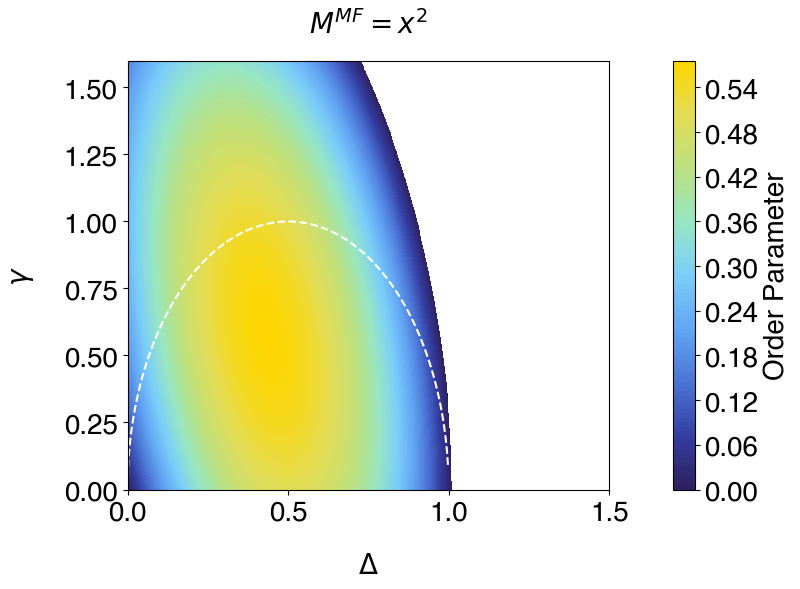

In [15]:
plt.figure(figsize=(8, 6))

colors = [
    '#2E1F5E',  # Dark indigo blue (background)
    '#343EA2',  # Indigo blue
    '#4B75D6',  # Medium blue
    '#62A6F3',  # Light blue
    '#7BCEF8',  # Cyan
    '#97E6C3',  # Teal
    '#BCE17F',  # Light green
    '#E2DC55',  # Yellow-green
    '#FFD700'   # Golden yellow (center)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.contourf(Delta, gamma, order_param, levels=100, cmap=custom_cmap)
plt.colorbar(label='Order Parameter', pad=0.1)
plt.contour(Delta, gamma, contour_values, levels=[0], colors='white', linestyles='dashed')
plt.xlabel(r'$\Delta$', labelpad=20)
plt.ylabel(r'$\gamma$', labelpad=20)
plt.title(r'$M^{MF} = x^{2}$', pad=20)
plt.tight_layout()
#plt.savefig('phase_diagram.pdf', dpi=600, bbox_inches='tight')
plt.show()

In [7]:
# Variational ansatz.
import qiskit
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

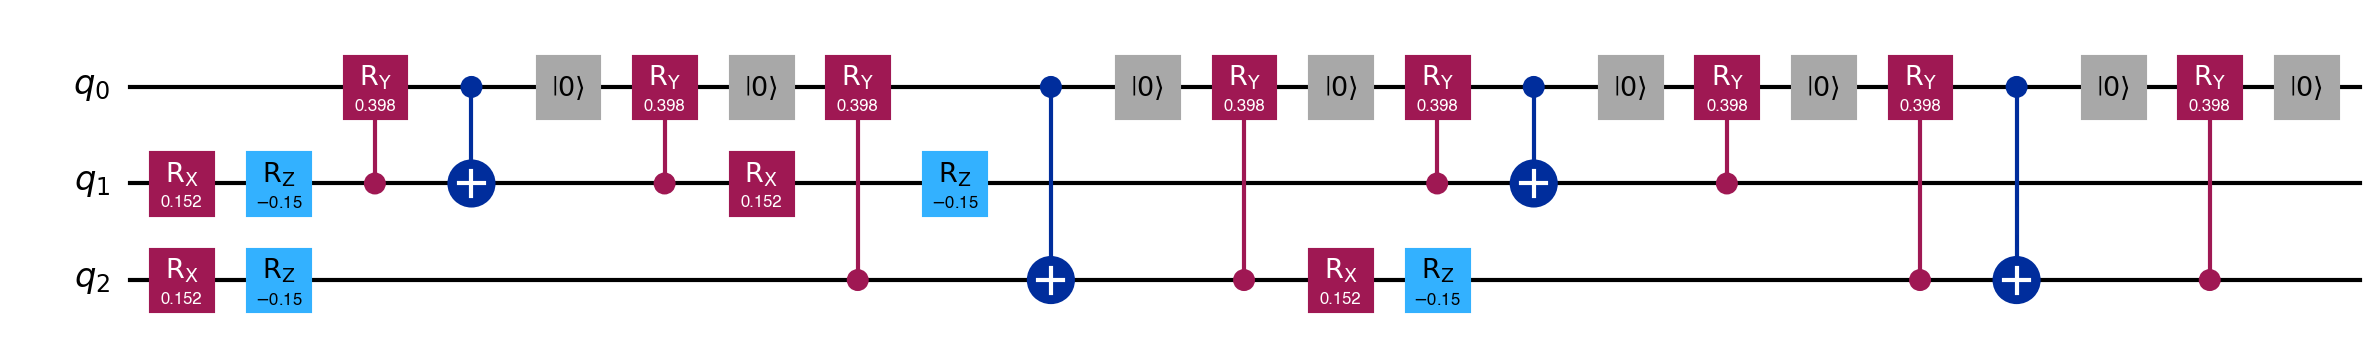

In [8]:
def variationl_circuit(Delta, L, J, x, dt, num_layer, num_qubit):

     theta_2 = J * L * x * dt
     theta_3 = - Delta * dt
     theta_r = np.arcsin(np.sqrt(gamma * dt))
     theta_d = np.arcsin(np.sqrt(gamma * dt))

     qc = QuantumCircuit(num_qubit)
     for layer in range(num_layer):
          for qubit in range(1,num_qubit):
               qc.rx(theta_2,qubit)
               qc.rz(theta_3,qubit)

               qc.cry(theta_r, qubit, 0)
               qc.cx(0, qubit)

               qc.reset(0)

               qc.cry(theta_d, qubit, 0)

               qc.reset(0)  

     return qc

Delta = 1.5
L = 100
J = 1 / ( L - 1 )
gamma = 1.5
dt = 0.1
x = 1.5
variationl_circuit(Delta, L, J, x, dt, 2, 3).draw('mpl', scale = 1.5)#.savefig('variational_circuit.pdf', dpi=600, bbox_inches='tight')